# 00 FGSM to Module

Re-writing FGSM attack to be used in any network within `adversarial`.

# Imports

In [188]:
import os

import torch
from torch import nn
import torchvision

from adversarial.networks import (MyNet,
                                  GoodfellowD,
                                  GoodfellowG,
                                  GoodfellowGAN)
from adversarial.attacks import fgsm

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [189]:
!pwd

/Users/u6070354/Desktop/Brian/research/thesis/adv/anti_adv/experiments/fgsm_mnist/notebooks


In [190]:
# Directories
EXP_DATA = os.path.abspath(os.path.join("..", "data", "01_raw"))

directories = [EXP_DATA]

# CUDA availability    
DEVICE = torch.device(0) if torch.cuda.is_available() else 'cpu'
print(f"using {DEVICE =}")

using DEVICE ='cpu'


# Dataset

In [191]:
img_size = 28
ds_train = torchvision.datasets.MNIST(EXP_DATA, train=True, download=True,
                                transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize((img_size,img_size)),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ]))
ds_test = torchvision.datasets.MNIST(EXP_DATA, train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize((img_size,img_size)),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Lambda((lambda x: torch.flatten(x))),
                            ]))

ds = torch.utils.data.Subset(ds_train, range(1024))
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)

In [192]:
# Extract 10 digits from MNIST, brute force because 

search_new = True
digits = []
labels = []
if search_new:
    x_class = []
    for i in range(0, 10):
        while True:
            j = torch.randint(0, len(ds), (1,))
            x,t = ds.__getitem__(j)
            if t == i:
                digits.append(x)
                labels.append(t)
                x_class.append(j)
                break
            else:
                continue

    print("completed")        
    print(x_class)
    x_class = torch.stack(x_class).view(-1)
    digits = torch.stack(digits)
    labels = torch.tensor(labels).reshape((-1,1))
else:
    x_class = torch.tensor([260, 315, 893, 298, 682, 635, 494, 446, 197, 974])
# Create a batch with those 10 samples
ds_digits = torch.utils.data.Subset(ds, x_class)
dl_digits = torch.utils.data.DataLoader(ds_digits, batch_size=len(ds_digits))
x,t = next(iter(dl_digits))
t = t.reshape((-1,1))

completed
[tensor([745]), tensor([671]), tensor([190]), tensor([433]), tensor([616]), tensor([899]), tensor([665]), tensor([518]), tensor([528]), tensor([520])]


# Plotting

In [193]:
def draw(X):
    img_size = 28
    def draw_single(x): 
        with torch.no_grad():
            plt.imshow(x.detach().cpu().numpy().reshape((img_size, img_size)), cmap='gray');
            plt.axis('off');

    if len(X.shape)==4 or len(X.shape)==2:  # display a batch
        N = X.shape[0]
        plt.figure(figsize=(15,3))
        for k,xx in enumerate(X):
            plt.subplot(1,10,k+1)
            draw_single(xx)
    else:
        draw_single(X)

# Test on Each Network

## MyNet

## GoodfellowGAN

In [194]:
img_size = 28**2
latent_dim = 10
hidden_dim = 5
device = DEVICE

g_args = {"img_size": img_size, 
          "latent_dim": latent_dim,
          "hidden_dim": hidden_dim,
          "device": device}

d_args = {"img_size": img_size, 
          "latent_dim": latent_dim,
          "device": device}

g = GoodfellowG(**g_args)
d = GoodfellowD(**d_args)

gf_args = {"G": g,
           "D": d,
           "img_size": img_size, 
           "latent_dim": latent_dim,
           "hidden_dim": hidden_dim,
           "device": device}

gnet = GoodfellowGAN(**gf_args)

optimizer=torch.optim.Adam(gnet.parameters(), lr=0.001)

In [195]:
outpath = os.path.abspath(os.path.join("..", "data", "05_models"))
if not os.path.exists(outpath):
    os.makedirs(outpath)
    print(f"made {outpath}")

In [196]:
gnet.train(dl, optimizer=optimizer, epochs=10, checkpoints=[0,5,9], path=outpath)

100%|██████████| 10/10 [00:02<00:00,  4.33it/s]


fgsm has to be called on the discriminator 

Untargetted:

In [260]:
y = gnet.D(digits)

In [261]:
y

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<ClampBackward>)

# TODO: requires full class logits outputs for GAN

In [ ]:
loss = torch.nn.NLLLoss()
a = torch.tensor([[0.,1.],[2.,3.],[4.,5.]], requires_grad=True).view(-1,1)
b = torch.tensor([0,1,0], requires_grad=False)
print(f"shape a: {a.shape}")
print(f"shape b: {b.shape}")
l = loss(a, b)

In [254]:
gnet.D.classifier_loss(y.reshape(1,-1), t.reshape(1,-1))

RuntimeError: 1D target tensor expected, multi-target not supported

In [151]:
# Call fgsm on that batch
x_adv = fgsm(gnet.D, x=digits, t=labels, eps=0.05, targ=False)

IndexError: Target 1 is out of bounds.

In [177]:
x_adv.shape

torch.Size([10, 784])

In [178]:
gnet.D(x_adv)

tensor([[1.0000],
        [1.0000],
        [0.7918],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], grad_fn=<ClampBackward>)

TypeError: unsupported format string passed to Tensor.__format__

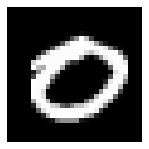

In [180]:
plt.figure(figsize=(14,7))
y = gnet.D(x_adv)
for n,xx in enumerate(x_adv):
    k = torch.argmax(y[n])
    plt.subplot(2,5,n+1); draw(xx);
    plt.title(f'y_{t[n]} = {y[n,t[n]]:0.5f}\ny_{k} = {y[n,k]:0.5f}', fontsize=16)
plt.tight_layout()
#plt.savefig('untargetted_adv.pdf')